# TDDE16 - Project

### Description
Get song lyrics and detect if the lyrics are containing bad words and then mark the song as “Explicit”. Check from explicit songs in Spotify as golden standard. Replace the explicit word with a suitable non-explicit word.

Using Genius and Spotify API :) 


## Data retrieval

In [1]:
import requests
import json
import base64
import time
import os
import re
from bs4 import BeautifulSoup
import sys
import nltk, random
import matplotlib.pyplot as plt
from nltk.stem.lancaster import LancasterStemmer

### Spotify - Track Retriever

In [2]:
class TrackRetriever():
    def __init__(self):
        self.request_token()
        
    # Requests an OAuth token required by the Spotify API
    def request_token(self):
        # Client ID and secret for Spotify Application
        client_id = '055a803e06f848a9a6b18ec76aafbe6e'
        client_secret = '756b412f52d54b49bd4e2fa0b2f0df15'
        # Encode client ID and secret in base64
        string = ':'.join([client_id, client_secret])
        encoded = base64.b64encode(string.encode())
        # Add encoding to header
        header = { "Authorization" : "Basic " + encoded.decode('utf-8')}
        data = {"grant_type" : "client_credentials"}
        # Url for requesting OAuth token for Spotify API
        url = "https://accounts.spotify.com/api/token" 
        response = requests.post(url, data=data, headers=header)
        # Store OAuth token in class
        self.token = response.json()['access_token']
        if not self.token:
            print("Error receiving token!")
            print(response.json())
    
    # Gets track id of all songs in a playlist. 
    # Input is an Spotify URI of a playlist
    def get_tracks_from_playlist(self, spotify_uri):
        track_list = []
        split = spotify_uri.split(":")
        user = split[2]
        playlist_id = split[4]
        header = { "Authorization" : "Bearer " + self.token}
        url = "https://api.spotify.com/v1/users/{}/playlists/{}/tracks".format(user, playlist_id)
        response = requests.get(url, headers=header)
        json_res = response.json()
        for track in json_res['items']:
            track_list.append(track['track'])

        # If the playlist contains more than 100 tracks the result is split up
        # and fetched via a different URL
        while json_res['next'] is not None:
            url = json_res['next']
            response = requests.get(url, headers=header)
            json_res = response.json()            
            for track in json_res['items']:
                track_list.append(track['track'])
        
        return track_list
    
    # Extracts track title, artist name and explicit bool from a track json
    def extract_info(self, track):
        # Join all artists to one string separated by a whitespace
        artists = " ".join([str(art['name']) for art in track['artists']])
        # Extract title and explicit status
        title = track['name']
        explicit = track['explicit']
        track_id = track['id']
        return {'id': track_id, 'artist': artists, 'title': title, 'explicit': explicit}
    
    # Starting method for retrieving songs from a playlist
    def get_track_info(self, uri):
        track_list = []
        tracks = self.get_tracks_from_playlist(uri)
        for t in tracks:
            track_list.append(self.extract_info(t))
        return track_list
            
        
# spotify:user:spotify:playlist:37i9dQZF1E9RVkbMAXdy3v        

### Genius - Lyrics Catcher

In [3]:
class LyricsCatcher():
    def __init__(self, token):
        self.oauth_token = token
        self.api_url = "http://api.genius.com"
        self.api_headers = {'Authorization': 'Bearer ' + token}
        self.web_url = "https://genius.com"
        
    def search_song(self, song_title, artist_name):
        search_url = "{}/search?q={}{}".format(self.api_url, song_title, artist_name)
        response = requests.get(search_url, headers=self.api_headers)
        json = response.json()
        song_info = None
        for hit in json["response"]["hits"]:
            if hit["result"]["primary_artist"]["name"] in artist_name:
                song_info = hit
                break
        return song_info
    
    def get_url(self, song_id):
        endpoint = "/songs/{}".format(song_id)
        # Get song info from API using the song ID
        response = requests.get(self.api_url + endpoint, headers=self.api_headers)
        return response.json()["response"]["song"]["path"]
    
    def get_lyrics(self, endpoint):
        # Fetch page containing the lyrics
        u = self.web_url + endpoint
        page = requests.get(u)
        # Extract HTML source code from page
        html = BeautifulSoup(page.text, "html.parser")
        # Remove script tags that they put in the middle of the lyrics
        [h.extract() for h in html('script')]
        # Get the div-tag where the lyrics are and extract text inside
        lyrics = html.find("div", class_="lyrics").get_text()
        lyrics = re.sub(r'\[.+\]', '', lyrics)
        lyrics = re.sub(r'\n+', ' ', lyrics)
        return lyrics
    
    def fetch_lyrics(self, title, artist):
        song = self.search_song(title, artist)
        if not(song):
            return None
        song_id = str(song["result"]["id"])
        path = self.get_url(song_id)
        lyrics = self.get_lyrics(path)
        return lyrics
        


## Dataset statistics script

## Data gathering
Using the Spotify API to get songs and explicit status and then use the genius API to search for lyrics

In [4]:
def read_track_id():
    track_id_set = set()
    json_data = []
    with open('track_id.json') as file:
        json_data = json.load(file)
    for track_id in json_data:
        track_id_set.add(track_id)
    return set(track_id_set)

# Read json file with data
def read_data():
    with open('data.json') as input_file:
        data = json.load(input_file)
    return data

# Plays a message on Mac OSX
def play_sound():
    for i in range(2):
        os.system('say "Programmet har kört klart!"')
        time.sleep(1)

In [5]:
elapsed = 0

def scrape_data():
    oauth_token = "O8rraozwWRK1i66ofhUJSZ9EDCBLkxg-gfoDzBB9_XH3Vjsm0qYoewK8C7lMOWkh"
    catcher = LyricsCatcher(oauth_token)
    tr = TrackRetriever()
    playlists = [
        'spotify:user:heekzz:playlist:5IeIXRXPSkRpBX9bNo5onK', # Test
        'spotify:user:heekzz:playlist:2FxBKjKF6QaXldXWdjcvK5', # Discover Weekly archive
        'spotify:user:heekzz:playlist:6nL0gtJLo2xqCWIirZ4inF', # Rockify
        'spotify:user:spotify:playlist:37i9dQZF1DXcF6B6QPhFDv', # Rock Classics
        'spotify:user:spotify:playlist:37i9dQZF1DX0XUsuxWHRQd', # Rapcaviar 
        'spotify:user:spotify:playlist:37i9dQZF1DWVA1Gq4XHa6U', # Gold School (Hiphop)
        'spotify:user:spotify:playlist:37i9dQZF1DX9dp45EzSeyl', # Top artists 2017
        'spotify:user:spotify:playlist:37i9dQZF1DWY4xHQp97fN6', # Get Turnt (Hiphop)
        'spotify:user:spotify:playlist:37i9dQZF1DXcA6dRp8rwj6', # Beats and Rhymes (Hiphop)
        'spotify:user:spotify:playlist:37i9dQZF1DX4o1oenSJRJd', # All out of 00's
        'spotify:user:heekzz:playlist:1wyfKl8G7LTo6aDmSAnNGn', # Explicit only (selfmade)
        'spotify:user:spotify:playlist:37i9dQZF1DWX4OQBd6GoaY', # Re:Play
        'spotify:user:spotify:playlist:37i9dQZF1DXbYM3nMM0oPk', # Mega Hits mix
        'spotify:user:spotify:playlist:37i9dQZF1DX0s5kDXi1oC5', # Hit Rewind
        'spotify:user:spotify:playlist:37i9dQZF1DX1lVhptIYRda', # Hot Country
        'spotify:user:1217276962:playlist:0PDEwXJAIUAzBUZYeMLgRf', # Sing a long
        'spotify:user:derpgasm:playlist:4f21f0VhTiIzZf1vMI0dDY', # The rap collection
        'spotify:user:heekzz:playlist:6lQxvXBQYdusu9DL5FIr0F', # Stepping with the wolfs
        'spotify:user:21cac4a7helevxexvi46d6a6a:playlist:6XcxyuSl7CLOYGMm6fW4V1', # Rap collection 2017
        'spotify:user:1293333339:playlist:1jADzvTmI3iEMFKmlH9vnh', # Classic rock collection
    ]
    tic = time.time()
    tracks_with_lyrics = read_data()
    track_id_set = read_track_id()
    for pl in playlists:
        try:
            tracks = tr.get_track_info(pl)
            track_counter = 0
            for t in tracks:
                if t['id'] not in track_id_set:
                    track_id_set.add(t['id'])
                    lyrics = catcher.fetch_lyrics(t['title'], t['artist'])
                    if lyrics != None:
                        data = {'id': t['id'], 'artist': t['artist'], 'title': t['title'], 'explicit': t['explicit'], 'lyrics': lyrics}
                        tracks_with_lyrics.append(data)

                track_counter += 1        
                elapsed = (time.time() - tic)
                m, s = divmod(elapsed, 60)
                h, m = divmod(m, 60)
                print ("Tracks processed: {}/{}, Lyrics found: {} Duration: {:.0f}:{:.0f}:{:.0f}     " \
                       .format(track_counter, len(tracks), len(tracks_with_lyrics), h, m, s), end="\r") 
            # Save file as json
            with open('data.json', 'w') as output:
                json.dump(tracks_with_lyrics, output, indent=2)
            with open('track_id.json', 'w') as output_id:
                json.dump(list(track_id_set), output_id, indent=2)
        except:
            print("Got error: {}".format(sys.exc_info()[0]))
            continue
    play_sound()
    
# Uncomment to scrape data
# scrape_data()

### Evaluation scipts

In [6]:
# Method for printing statistics of the tracks
def stats(tracks):
    explicit_counter = 0
    non_explicit_counter = 0
    
    for track in tracks:
        if track['explicit']:
            explicit_counter += 1
        else:
            non_explicit_counter += 1
    total = len(tracks)
    print("Total number of lyrics: " + str(total))
    print("Explicit tracks:\t {0:.2f}% ({1})".format((explicit_counter/total)*100, explicit_counter))
    print("Non-Explicit tracks:\t {0:.2f}% ({1})".format((non_explicit_counter/total)*100, non_explicit_counter))
    
# Method for evaluating a classifier
# Returns accuracy, precision, recall and F1-measre
def evaluate(classifier, data):
    tp, fp, tn, fn  = 0,0,0,0
    total = len(data)
    for x in data:
        y = classifier.predict(x[0]) 
        if y == 'True':
            if x[1] ==  'True':
                tp += 1
            else:
                fp += 1
        if y == 'False':
            if x[1] == 'False':
                tn += 1
            else:
                fn += 1
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision * recall)/(precision + recall)) #8 + 6
    #print("Accuracy: {:=7.2f}".format(accuracy*100))
    #print("Precision: {:=6.2f}".format(precision*100))
    #print("Recall: {:=9.2f}".format(recall*100))
    #print("F1-measure: {:=4.2f}".format(f1*100))
    return accuracy, precision, recall, f1



### Read file with saved lyrics

In [7]:
data = read_data()
stats(data)

Total number of lyrics: 3598
Explicit tracks:	 51.22% (1843)
Non-Explicit tracks:	 48.78% (1755)


## Pre-processing

1. Tokenize 
2. Stem words
4. Make lowercase
3. Remove stop words

In [8]:
#nltk.download()
st = LancasterStemmer()

print("Data length: " + str(len(data)))
# Tokenize and remove english stop words
count = 0
for track in data:
    count+=1
    print("Progress: {}".format((count/len(data))*100, end="\r"))
    track['lyrics'] = nltk.word_tokenize(track['lyrics'])
    track['lyrics'] = [st.stem(word.lower()) for word in track['lyrics'] if word not in nltk.corpus.stopwords.words('english')]

Data length: 3598


Split into training and test set

In [9]:
# Binarize the data so that every word only appears once in the training and test set
def binarize(data):
    new_data = []
    for lyrics in data:
        new_data.append([list(set(lyrics[0])),lyrics[1]])
    return new_data

# Shuffle the data
random.shuffle(data)
    
# Save dataset containing only lyrics and classification 
data_set = [(t['lyrics'], str(t['explicit'])) for t in data]
print("Data_set length: " + str(len(data_set)))

# test data = 20%
num_of_test = round(len(data_set) / 5);

# train data = 80%
num_of_train = len(data_set) - num_of_test

print("Train length: " + str(num_of_train))
print("Test length: " + str(num_of_test))


# Split data into training and test data
train_set, test_set  = data_set[:num_of_train], data_set[-num_of_test:]
print("Train_set length: " + str(len(train_set)))
print("Test_set length: " + str(len(test_set)))

Data_set length: 3598
Train length: 2878
Test length: 720
Train_set length: 2878
Test_set length: 720


## Multi class perceptron classifier

In [10]:
class PerceptronClassifier():

    def predict(self, lyrics):
        scores = {'True': 0, 'False': 0} # maps classes to scores
        for c in ['True', 'False']:
            for word in lyrics:
                if word in self.weights[c]:
                     scores[c] += self.weights[c][word] #* x[f]
                else: 
                    self.weights[c].update({word:0})
                    self.accumilator[c].update({word:0})
        return max(scores, key=lambda c: scores[c])
        
    @classmethod
    def train(cls, data, n_epochs=1, average=True):
        mpc = cls()
        mpc.weights = {'True':{}, 'False' : {}}
        mpc.accumilator = {'True':{}, 'False':{}}
        count=1
        for e in range(0, n_epochs):
            for lyrics in data: 
                p = mpc.predict(lyrics[0])
                y = lyrics[1]
                
                if p != y:
                    for word in lyrics[0]:
                        mpc.weights[p][word] -= 1
                        mpc.weights[y][word] += 1
                        mpc.accumilator[p][word] -= count
                        mpc.accumilator[y][word] += count
                count+=1
        # Averaging
        if average:
            for c in ['True','False']:
                for word in mpc.weights[c]:
                    mpc.weights[c][word]-=mpc.accumilator[c][word]/count

        return mpc

In [11]:
counter_t, counter_f = 0, 0
for l, e in train_set:
    if e == 'True':
        counter_t += 1
    else:
        counter_f += 1
print("Num of explicit: {}".format(counter_t))
print("Num of non-explicit: {}".format(counter_f))
print(len(train_set))
print(len(test_set))

Num of explicit: 1467
Num of non-explicit: 1411
2878
720


Evaluate model with different epochs

Epoch: 1, Accuracy: 0.82, Precision: 0.82, Recall: 0.86, F1: 0.84
Epoch: 2, Accuracy: 0.84, Precision: 0.82, Recall: 0.88, F1: 0.85
Epoch: 3, Accuracy: 0.84, Precision: 0.83, Recall: 0.89, F1: 0.86
Epoch: 4, Accuracy: 0.84, Precision: 0.83, Recall: 0.88, F1: 0.86
Epoch: 5, Accuracy: 0.85, Precision: 0.84, Recall: 0.88, F1: 0.86
Epoch: 6, Accuracy: 0.85, Precision: 0.84, Recall: 0.88, F1: 0.86
Epoch: 7, Accuracy: 0.85, Precision: 0.84, Recall: 0.88, F1: 0.86
Epoch: 8, Accuracy: 0.85, Precision: 0.84, Recall: 0.88, F1: 0.86
Epoch: 9, Accuracy: 0.85, Precision: 0.84, Recall: 0.88, F1: 0.86
Epoch: 10, Accuracy: 0.84, Precision: 0.83, Recall: 0.88, F1: 0.85
Epoch: 11, Accuracy: 0.84, Precision: 0.83, Recall: 0.87, F1: 0.85
Epoch: 12, Accuracy: 0.84, Precision: 0.83, Recall: 0.87, F1: 0.85
Epoch: 13, Accuracy: 0.83, Precision: 0.82, Recall: 0.86, F1: 0.84
Epoch: 14, Accuracy: 0.83, Precision: 0.82, Recall: 0.87, F1: 0.84
Epoch: 15, Accuracy: 0.83, Precision: 0.82, Recall: 0.87, F1: 0.84
Epoc

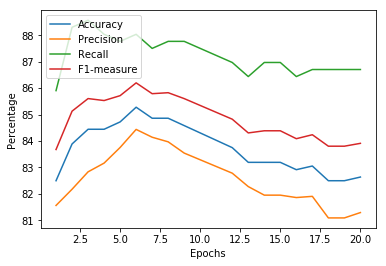

In [18]:
acc, pres, rec, f1, e = [], [], [], [], [] 
for epoch in range(1,21):
    e.append(epoch)
    pc = PerceptronClassifier().train(train_set, epoch)
    a, p, r, f = evaluate(pc, test_set)
    acc.append(a*100)
    pres.append(p*100)
    rec.append(r*100)
    f1.append(f*100)
    print("Epoch {}: Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%, F1: {:.2f}%".format(epoch, a*100, p*100, r*100, f*100))
    print("Progress: {:.2f}%  ".format((epoch/21)*100), end="\r")
plt.plot(e, acc, label='Accuracy')
plt.plot(e, pres, label='Precision')
plt.plot(e, rec, label='Recall')
plt.plot(e, f1, label='F1-measure')
plt.xlabel('Epochs')
plt.ylabel('Percentage')
plt.legend()
plt.show()

Plotting the data to see best matching epochs

Epoch 1: Accuracy: 0.82, Precision: 0.92, Recall: 0.72, F1: 0.81
Epoch 2: Accuracy: 0.82, Precision: 0.95, Recall: 0.69, F1: 0.80
Epoch 3: Accuracy: 0.82, Precision: 0.93, Recall: 0.71, F1: 0.80
Epoch 4: Accuracy: 0.86, Precision: 0.91, Recall: 0.82, F1: 0.86
Epoch 5: Accuracy: 0.87, Precision: 0.90, Recall: 0.84, F1: 0.87
Epoch 6: Accuracy: 0.85, Precision: 0.91, Recall: 0.80, F1: 0.85
Epoch 7: Accuracy: 0.86, Precision: 0.88, Recall: 0.83, F1: 0.86
Epoch 8: Accuracy: 0.86, Precision: 0.84, Recall: 0.91, F1: 0.87
Epoch 9: Accuracy: 0.88, Precision: 0.87, Recall: 0.90, F1: 0.88
Epoch 10: Accuracy: 0.86, Precision: 0.82, Recall: 0.94, F1: 0.87
Epoch 11: Accuracy: 0.87, Precision: 0.87, Recall: 0.89, F1: 0.88
Epoch 12: Accuracy: 0.86, Precision: 0.83, Recall: 0.92, F1: 0.87
Epoch 13: Accuracy: 0.86, Precision: 0.83, Recall: 0.93, F1: 0.88
Epoch 14: Accuracy: 0.85, Precision: 0.81, Recall: 0.93, F1: 0.87
Epoch 15: Accuracy: 0.85, Precision: 0.81, Recall: 0.93, F1: 0.87
Epoch 16: Accuracy:

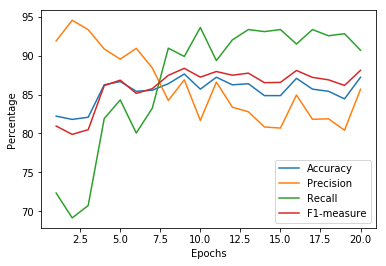

In [19]:
acc, pres, rec, f1, e = [], [], [], [], [] 
for epoch in range(1,21):
    e.append(epoch)
    pc = PerceptronClassifier().train(binarize(train_set), epoch, False)
    a, p, r, f = evaluate(pc, binarize(test_set))
    acc.append(a*100)
    pres.append(p*100)
    rec.append(r*100)
    f1.append(f*100)
    print("Epoch {}: Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%, F1: {:.2f}%".format(epoch, a*100, p*100, r*100, f*100))
    print("Progress: {:.2f}%  ".format((epoch/21)*100), end="\r")
plt.plot(e, acc, label='Accuracy')
plt.plot(e, pres, label='Precision')
plt.plot(e, rec, label='Recall')
plt.plot(e, f1, label='F1-measure')
plt.xlabel('Epochs')
plt.ylabel('Percentage')
plt.legend()
plt.show()
play_sound()